In [1]:
import sys
import matplotlib.pyplot as plt
import os
import jax

os.environ['CUDA_VISIBLE_DEVICES'] = '4, 6'
pid = os.getpid()
devs = jax.devices()
ldevs = jax.local_devices()
print(f"pid={pid}, devices={devs}, local_devices={ldevs}")

pid=1966778, devices=[gpu(id=0), gpu(id=1)], local_devices=[gpu(id=0), gpu(id=1)]


In [2]:
jax.local_device_count() 

2

In [3]:
import sys
import matplotlib.pyplot as plt
import os

sys.path.append('/home/davcic/CP_Testing')
# args = '5, 6'
# os.environ['CUDA_VISIBLE_DEVICES'] = f'{args}'

# if isinstance(args, str):
#     print(f'Selected CPU')
# else:
#     print(f'Selected GPU {args}')
    
from load_dataset import TimeSeries
import jax
import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import jaxkern as jk
import pandas as pd
import copy

from jax.config import config
config.update("jax_enable_x64", True)  # crucial for Gaussian processes

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from uicsmodels.gaussianprocesses.fullgp import FullLatentGPModel, FullMarginalGPModel
from gputil_new import sample_prior, sample_predictive
from jax.tree_util import tree_flatten, tree_unflatten

plt.style.use('default')

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from New_kernel_1 import Discontinuous_multiple
from New_kernel_1 import Discontinuous_multiple_params
from New_kernel_1 import Discontinuous_multiple_params_hyper
from New_kernel_1 import Discontinuous_multiple_params_hyper_periodic, Discontinuous_multiple_params_hyper_linear
from Poisson_Process_added import Poisson_Process_hyper
from fullgp import FullMarginalGPModelhyper_mult
from Uniform_modified import Uniform_mod
from Normal_modified import LogNormal_mod

In [6]:
readname = 'jfk_passengers'
savename = "jfk_passengers"
path = f'./{savename}'
# os.mkdir(path)

468


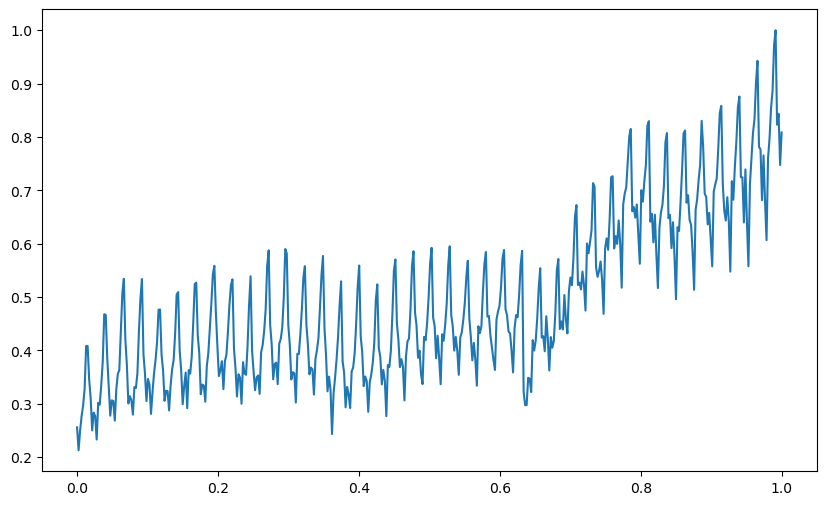

In [7]:
data = TimeSeries.from_json(f'datasets/{readname}/{readname}.json')
fig = plt.figure(figsize = (10, 6))
# y_data = data.y[15:]
print(len(data.y))
# x_data = data.t[15:]-15
corr_data = data.y/jnp.max(data.y)
plt.plot(data.t/(len(data.t)-1), corr_data)

In [8]:
key = jrnd.PRNGKey(123456)

size = 10
T = 1
max_CP = size
base_kernel1 = jk.Periodic()
base_kernel2 = jk.Linear()

# kernel = Discontinuous_multiple_params_hyper(base_kernel1)
# kernel = Discontinuous_multiple_params_hyper_periodic(base_kernel2)
kernel = Discontinuous_multiple_params_hyper_periodic(base_kernel1) + Discontinuous_multiple_params_hyper_linear(base_kernel2)

priors = dict(kernel= [dict(lengthscale=LogNormal_mod(0, 2, max_CP+1),
                              variance=LogNormal_mod(0, 2, max_CP+1),
                              period=LogNormal_mod(0, 2, max_CP+1),
                              num=Poisson_Process_hyper(size, T)),
                        dict(variance=LogNormal_mod(0, 2, max_CP+1), 
                           num=Poisson_Process_hyper(size, T))],
              likelihood=dict(obs_noise=dx.Transformed(dx.Normal(loc=0.,
                                                                 scale=1.),
                                                       tfb.Exp())),
              hyper = [dict(hyper_1 = dx.Transformed(dx.Normal(loc=0.,
                                                               scale=1.),
                                                     tfb.Exp())), 
                       dict(hyper_2 = dx.Transformed(dx.Normal(loc=0.,
                                                               scale=1.),
                                                     tfb.Exp()))])

x = jnp.array(data.t/(len(data.t)-1))[:, jnp.newaxis]
y = corr_data.flatten()
# gp_marginal = FullMarginalGPModelhyper_mult(x, y, cov_fn=kernel, priors=priors)  # Implies likelihood=Gaussian()

num_particles = 1000
num_mcmc_steps = 100

In [9]:
sys.path.append('/home/davcic/CP_Testing/Classes')

from GP_CP import GP_CP_Marginal, GP_CP_Latent
num_particles = 1000
num_mcmc_steps = 100
GP_marginal = GP_CP_Marginal(x, y, cov_fn=kernel, priors=priors, num_particles=num_particles, num_mcmc_steps=num_mcmc_steps)

In [58]:
particles = jnp.load(f"{readname}/{readname}_particles_lin_per.npy", allow_pickle = True)[()]

/home/davcic/.conda/envs/CPJax/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/davcic/.conda/envs/CPJax/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


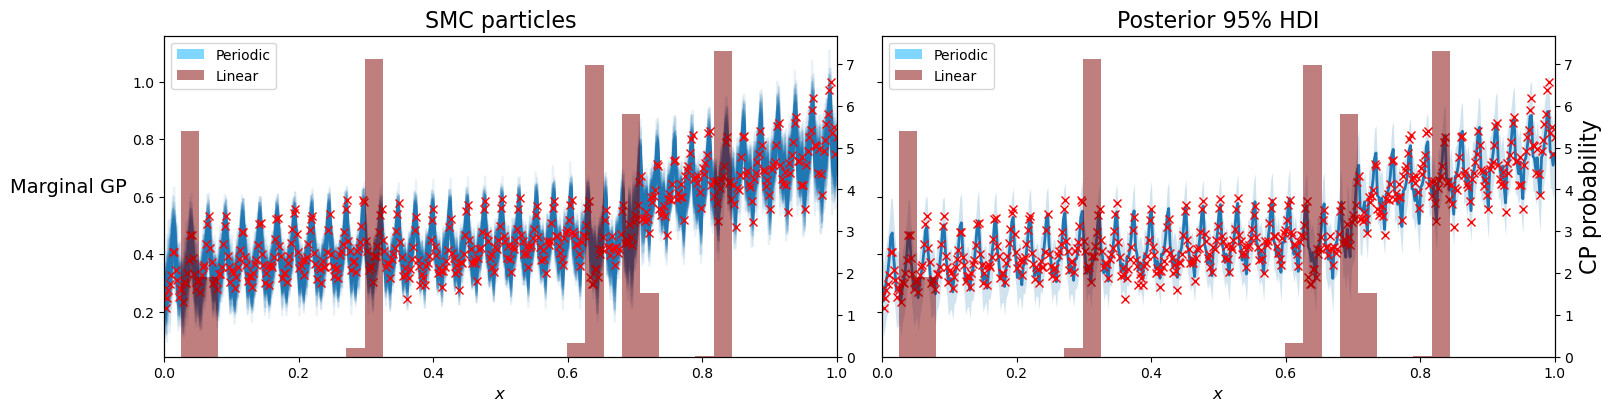

In [59]:
key, subkey = jrnd.split(key)
# particles = jnp.load(f"{readname}/{readname}_particles_lin_per.npy", allow_pickle = True)[()]
GP_marginal.plot_fit(key, False, None, None, particles)

In [62]:
from blackjax.smc.tempered import TemperedSMCState
smc_particles = TemperedSMCState(particles, jax.Array(), 0.)

In [65]:
GP_marginal.particles = smc_particles

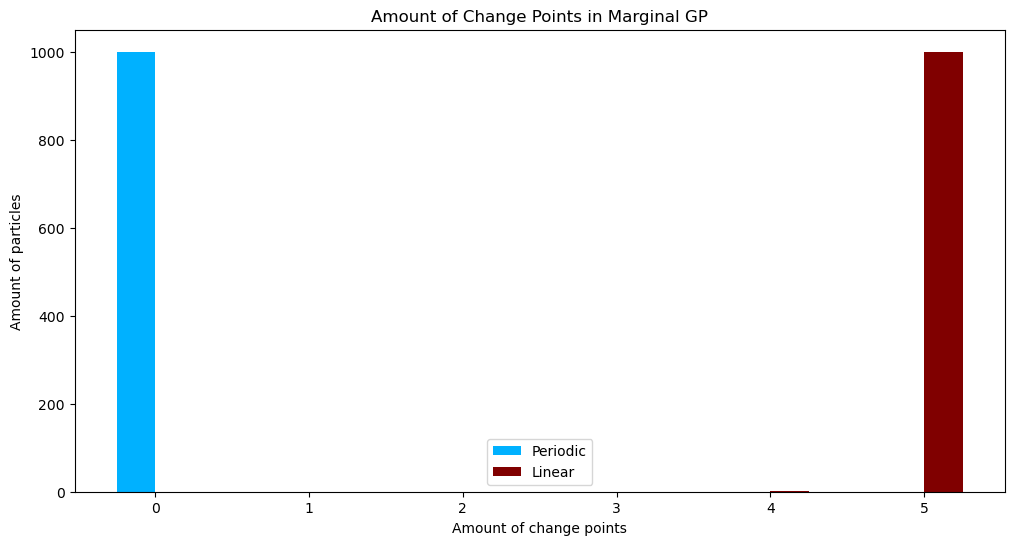

In [66]:
GP_marginal.plot_num()

In [53]:
def predict_f_particle(key, x_pred, particles, num_subsample=-1):
        """Predict the latent f on unseen pointsand

        This function takes the approximated posterior (either by MCMC or SMC)
        and predicts new latent function evaluations f^*.

        Args:
            key: PRNGKey
            x_pred: x^*; the queried locations.
            num_subsample: By default, we return one predictive sample for each
            posterior sample. While accurate, this can be memory-intensive; this
            parameter can be used to thin the MC output to every n-th sample.

        Returns:
            f_samples: An array of samples of f^* from p(f^* | x^*, x, y)


        todo:
        - predict using either SMC or MCMC output
        - predict from prior if desired
        """
        if jnp.ndim(x_pred) == 1:
            x_pred = x_pred[:, jnp.newaxis]

        samples = copy.deepcopy(particles)
        flat_particles, _ = tree_flatten(samples)
        num_particles = flat_particles[0].shape[0]
        key_samples = jrnd.split(key, num_particles)

        mean_params = samples.get('mean', {})
        cov_params = samples.get('kernel', {})
        mean_params_in_axes = jax.tree_map(lambda l: 0, mean_params)
        cov_param_in_axes = jax.tree_map(lambda l: 0, cov_params)
        sample_fun = lambda key, mean_params_, cov_params_, obs_noise_: sample_predictive(key,
                                                                            mean_params=mean_params_,
                                                                            cov_params=cov_params_,
                                                                            mean_fn=GP_marginal.mean_fn,
                                                                            cov_fn=GP_marginal.cov_fn,
                                                                            x=GP_marginal.X,
                                                                            z=x_pred,
                                                                            target=GP_marginal.y,
                                                                            obs_noise=obs_noise_)
        
        keys = jrnd.split(key, num_particles)
        
        key_subset1 = keys[:500]
        key_subset2 = keys[500:1000]
        key_subset_list = jnp.array([key_subset1, key_subset2])
        # print(key_subset_list.shape)
        if isinstance(cov_params, dict):
            if 'num' in cov_params.keys():            
                cov_params['num'] = jnp.append(cov_params['num'], jnp.full((cov_params['num'].shape[0], 1), jnp.nan), axis=1)
        else:
             for i, param in enumerate(cov_params):
                  if 'num' in cov_params[i].keys():            
                    cov_params[i]['num'] = jnp.append(cov_params[i]['num'], jnp.full((cov_params[i]['num'].shape[0], 1), jnp.nan), axis=1)
        
        cov_params_subset1 = jax.tree_map(lambda l: l[:500], cov_params)
        cov_params_subset2 = jax.tree_map(lambda l: l[500:1000], cov_params)
        cov_params_subset1_flat, subset1_tree_def = jax.tree_util.tree_flatten(cov_params_subset1)
        cov_params_subset2_flat, subset2_tree_def = jax.tree_util.tree_flatten(cov_params_subset2)
        
        
        cov_params_subset_array1 = jnp.zeros((1, cov_params_subset1_flat[0].shape[0], cov_params_subset1_flat[0].shape[1]))
        cov_params_subset_array2 = jnp.zeros((1, cov_params_subset2_flat[0].shape[0], cov_params_subset1_flat[0].shape[1]))
        for arr in cov_params_subset1_flat:
             cov_params_subset_array1 = jnp.concatenate((cov_params_subset_array1, jnp.expand_dims(arr, 0)))
            
        for arr in cov_params_subset2_flat:
             cov_params_subset_array2 = jnp.concatenate((cov_params_subset_array2, jnp.expand_dims(arr, 0)))

        cov_params_subset_array1_new = cov_params_subset_array1[1:, :, :]
        cov_params_subset_array2_new = cov_params_subset_array2[1:, :, :]

        cov_params_subset_array = jnp.array([cov_params_subset_array1_new, cov_params_subset_array2_new])

        lik_samples1 = samples['likelihood']['obs_noise'][:500]
        lik_samples2 = samples['likelihood']['obs_noise'][500:1000]
        lik_subset_list = jnp.array([lik_samples1, lik_samples2])

       
        def vmap_setup(key, m, cov, obs):
            new_cov = [x for x in cov]
            dict_cov = jax.tree_util.tree_unflatten(subset1_tree_def, new_cov)
            return jax.vmap(jax.jit(sample_fun), 
                              in_axes=(0, {k: 0 for k in mean_params}, cov_param_in_axes, 0))(key, m, dict_cov, obs)
        
        target_pred = jax.pmap(vmap_setup,
                                in_axes=(0,
                                        None,
                                        0,
                                        0), 
                                        devices = jax.devices())(key_subset_list,
                                                                    mean_params,
                                                                    cov_params_subset_array,
                                                                    lik_subset_list)
                

        return jnp.reshape(target_pred, (-1, len(GP_marginal.y)))

In [54]:
particles = jnp.load(f"{readname}/{readname}_particles_lin_per.npy", allow_pickle = True)[()]
predict_f_particle(key, jnp.linspace(0, 1, num=len(GP_marginal.y)), particles).shape

(1000, 468)

In [34]:
from blackjax.smc.tempered import sequential_vmap
